In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3821105/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "dOrg"
SPLITS_FREQ = "2d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-02-18"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 343 non-null    object        
 1   author             343 non-null    object        
 2   date               343 non-null    datetime64[us]
 3   start              343 non-null    datetime64[us]
 4   end                342 non-null    datetime64[us]
 5   platform_proposal  343 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 16.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        1782 non-null   object        
 1   proposal  1782 non-null   object        
 2   voter     1782 non-null   object        
 3   date      1782 non-null   datetime64[us]
dtypes: d

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/dOrg/baseline/folds-info_2d_normalize.parquet
fold
2023-06-13    1756
2023-06-15    1756
2023-06-17    1763
2023-06-19    1766
2023-06-21    1775
2023-06-23    1776
2023-06-25    1776
2023-06-27    1776
2023-06-29    1776
2023-07-01    1780
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W24,0,0,0,nan,nan,0,0,nan,nan
2023-W24,0,0,0,nan,nan,0,0,nan,nan
2023-W24,3,7,4,2.33,1.75,13,7,4.33,1.86
2023-W25,3,10,5,3.33,2.00,10,6,3.33,1.67
2023-W25,1,6,6,6.00,1.00,1,1,1.00,1.00
2023-W25,0,0,0,nan,nan,0,0,nan,nan
2023-W25,0,0,0,nan,nan,0,0,nan,nan
2023-W26,0,0,0,nan,nan,0,0,nan,nan
2023-W26,1,0,0,0.00,nan,6,6,6.00,1.00


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W24 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W24 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W24 & 3 & 7 & 4 & 2.33 & 1.75 & 13 & 7 & 4.33 & 1.86 \\
2023-W25 & 3 & 10 & 5 & 3.33 & 2.00 & 10 & 6 & 3.33 & 1.67 \\
2023-W25 & 1 & 6 & 6 & 6.00 & 1.00 & 1 & 1 & 1.00 & 1.00 \\
2023-W25 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W25 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W26 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W26 & 1 & 0 & 0 & 0.00 & nan & 6 & 6 & 6.00 & 1.00 \\
2023-W26 & 1 & 4 & 4 & 4.00 & 1.00 & 2 & 2 & 2.00 & 1.00 \\
\end{tabular}



## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/607 [00:00<?, ?it/s]

Warning, empty test fold 0 (2020-03-06 00:00:00), all ok since 0 folds ago
Warning, empty test fold 1 (2020-03-08 00:00:00), all ok since 1 folds ago


Warning, test fold 2 (2020-03-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 3 (2020-03-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 4 (2020-03-14 00:00:00), all ok since 3 folds ago
Warning, empty test fold 5 (2020-03-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 6 (2020-03-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 7 (2020-03-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 8 (2020-03-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 9 (2020-03-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 10 (2020-03-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 11 (2020-03-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 12 (2020-03-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 13 (2020-04-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 14 (2020-04-03 00:00:00), all ok since 1 folds ago
Warning, test fold 15 (2020-04-05 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 16 (2020-04-07 00:00:00), all ok since 2 folds ago
Warning, empty test fold 17 (2020-04-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 18 (2020-04-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 19 (2020-04-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 20 (2020-04-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 21 (2020-04-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 22 (2020-04-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 23 (2020-04-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 24 (2020-04-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 25 (2020-04-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 26 (2020-04-27 00:00:00), all ok since 1 folds ago
Warning, empty test fold 27 (2020-04-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 28 (2020-05-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 29 (2020-05-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 30 (2020-05-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 31 (2020-05-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 32 (2020-05-09 00:00:00), all ok since 1 folds ago
Warning, empty test fold 33 (2020-05-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 34 (2020-05-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 35 (2020-05-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 36 (2020-05-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 38 (2020-05-21 00:00:00), all ok since 2 folds ago
Warning, empty test fold 39 (2020-05-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 40 (2020-05-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 41 (2020-05-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 42 (2020-05-29 00:00:00), all ok since 1 folds ago
Warning, empty test fold 43 (2020-05-31 00:00:00), all ok since 1 folds ago


Warning, empty test fold 44 (2020-06-02 00:00:00), all ok since 1 folds ago
Warning, test fold 45 (2020-06-04 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 46 (2020-06-06 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 47 (2020-06-08 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 49 (2020-06-12 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, test fold 50 (2020-06-14 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 51 (2020-06-16 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 52 (2020-06-18 00:00:00), all ok since 8 folds ago
Warning, empty test fold 53 (2020-06-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 54 (2020-06-22 00:00:00), all ok since 1 folds ago
Warning, test fold 55 (2020-06-24 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 57 (2020-06-28 00:00:00), all ok since 3 folds ago
Warning, empty test fold 58 (2020-06-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 59 (2020-07-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 60 (2020-07-04 00:00:00), all ok since 1 folds ago


Warning, test fold 61 (2020-07-06 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, empty test fold 62 (2020-07-08 00:00:00), all ok since 2 folds ago


Warning, empty test fold 63 (2020-07-10 00:00:00), all ok since 1 folds ago
Warning, empty test fold 64 (2020-07-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 65 (2020-07-14 00:00:00), all ok since 1 folds ago
Warning, test fold 66 (2020-07-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 67 (2020-07-18 00:00:00), all ok since 2 folds ago
Warning, empty test fold 68 (2020-07-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 69 (2020-07-22 00:00:00), all ok since 1 folds ago
Warning, test fold 70 (2020-07-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 71 (2020-07-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 72 (2020-07-28 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 73 (2020-07-30 00:00:00), all ok since 4 folds ago
Warning, test fold 74 (2020-08-01 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 75 (2020-08-03 00:00:00), all ok since 2 folds ago
Warning, empty test fold 76 (2020-08-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 77 (2020-08-07 00:00:00), all ok since 1 folds ago
Warning, test fold 78 (2020-08-09 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 79 (2020-08-11 00:00:00), all ok since 2 folds ago
Warning, empty test fold 80 (2020-08-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 81 (2020-08-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 82 (2020-08-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 83 (2020-08-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 84 (2020-08-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 85 (2020-08-23 00:00:00), all ok since 1 folds ago
Warning, test fold 86 (2020-08-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 87 (2020-08-27 00:00:00), all ok since 2 folds ago
Warning, empty test fold 88 (2020-08-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 89 (2020-08-31 00:00:00), all ok since 1 folds ago
Warning, empty test fold 90 (2020-09-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 91 (2020-09-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 92 (2020-09-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 93 (2020-09-08 00:00:00), all ok since 1 folds ago
Warning, empty test fold 94 (2020-09-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 95 (2020-09-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 96 (2020-09-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 97 (2020-09-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 98 (2020-09-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 99 (2020-09-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 100 (2020-09-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 101 (2020-09-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 102 (2020-09-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 103 (2020-09-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 104 (2020-09-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 105 (2020-10-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 106 (2020-10-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 107 (2020-10-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 108 (2020-10-08 00:00:00), all ok since 1 folds ago
Warning, empty test fold 109 (2020-10-10 00:00:00), all ok since 1 folds ago


Warning, test fold 110 (2020-10-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, empty test fold 111 (2020-10-14 00:00:00), all ok since 2 folds ago


Warning, empty test fold 112 (2020-10-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 113 (2020-10-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 114 (2020-10-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 115 (2020-10-22 00:00:00), all ok since 1 folds ago


Warning, empty test fold 116 (2020-10-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 117 (2020-10-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 118 (2020-10-28 00:00:00), all ok since 1 folds ago
Warning, empty test fold 119 (2020-10-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 120 (2020-11-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 121 (2020-11-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 122 (2020-11-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 123 (2020-11-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 124 (2020-11-09 00:00:00), all ok since 1 folds ago
Warning, empty test fold 125 (2020-11-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 126 (2020-11-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 127 (2020-11-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 128 (2020-11-17 00:00:00), all ok since 1 folds ago
Warning, empty test fold 129 (2020-11-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 130 (2020-11-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 131 (2020-11-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 132 (2020-11-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 133 (2020-11-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 134 (2020-11-29 00:00:00), all ok since 1 folds ago
Warning, empty test fold 135 (2020-12-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 136 (2020-12-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 137 (2020-12-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 138 (2020-12-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 139 (2020-12-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 140 (2020-12-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 141 (2020-12-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 142 (2020-12-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 143 (2020-12-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 144 (2020-12-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 145 (2020-12-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 146 (2020-12-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 147 (2020-12-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 148 (2020-12-27 00:00:00), all ok since 1 folds ago
Warning, empty test fold 149 (2020-12-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 150 (2020-12-31 00:00:00), all ok since 1 folds ago
Warning, empty test fold 151 (2021-01-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 152 (2021-01-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 153 (2021-01-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 154 (2021-01-08 00:00:00), all ok since 1 folds ago
Warning, empty test fold 155 (2021-01-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 156 (2021-01-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 157 (2021-01-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 158 (2021-01-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 159 (2021-01-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 160 (2021-01-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 161 (2021-01-22 00:00:00), all ok since 1 folds ago


Warning, empty test fold 162 (2021-01-24 00:00:00), all ok since 1 folds ago
Warning, test fold 163 (2021-01-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 164 (2021-01-28 00:00:00), all ok since 2 folds ago
Warning, empty test fold 165 (2021-01-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 166 (2021-02-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 167 (2021-02-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 168 (2021-02-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 169 (2021-02-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 170 (2021-02-09 00:00:00), all ok since 1 folds ago
Warning, test fold 171 (2021-02-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 172 (2021-02-13 00:00:00), all ok since 2 folds ago
Warning, empty test fold 173 (2021-02-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 174 (2021-02-17 00:00:00), all ok since 1 folds ago
Warning, empty test fold 175 (2021-02-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 176 (2021-02-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 177 (2021-02-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 178 (2021-02-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 179 (2021-02-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 180 (2021-03-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 181 (2021-03-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 182 (2021-03-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 183 (2021-03-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 184 (2021-03-09 00:00:00), all ok since 1 folds ago
Warning, empty test fold 185 (2021-03-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 186 (2021-03-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 187 (2021-03-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 188 (2021-03-17 00:00:00), all ok since 1 folds ago
Warning, empty test fold 189 (2021-03-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 190 (2021-03-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 191 (2021-03-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 192 (2021-03-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 193 (2021-03-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 194 (2021-03-29 00:00:00), all ok since 1 folds ago
Warning, empty test fold 195 (2021-03-31 00:00:00), all ok since 1 folds ago


Warning, test fold 196 (2021-04-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, empty test fold 197 (2021-04-04 00:00:00), all ok since 2 folds ago


Warning, empty test fold 198 (2021-04-06 00:00:00), all ok since 1 folds ago
Warning, empty test fold 199 (2021-04-08 00:00:00), all ok since 1 folds ago


Warning, empty test fold 200 (2021-04-10 00:00:00), all ok since 1 folds ago
Warning, empty test fold 201 (2021-04-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 202 (2021-04-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 203 (2021-04-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 204 (2021-04-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 205 (2021-04-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 206 (2021-04-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 207 (2021-04-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 208 (2021-04-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 209 (2021-04-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 210 (2021-04-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 211 (2021-05-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 212 (2021-05-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 213 (2021-05-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 214 (2021-05-08 00:00:00), all ok since 1 folds ago
Warning, empty test fold 215 (2021-05-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 216 (2021-05-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 217 (2021-05-14 00:00:00), all ok since 1 folds ago


Warning, test fold 218 (2021-05-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, empty test fold 219 (2021-05-18 00:00:00), all ok since 2 folds ago


Warning, empty test fold 220 (2021-05-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 221 (2021-05-22 00:00:00), all ok since 1 folds ago


Warning, empty test fold 222 (2021-05-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 223 (2021-05-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 224 (2021-05-28 00:00:00), all ok since 1 folds ago
Warning, empty test fold 225 (2021-05-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 226 (2021-06-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 227 (2021-06-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 228 (2021-06-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 229 (2021-06-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 230 (2021-06-09 00:00:00), all ok since 1 folds ago
Warning, empty test fold 231 (2021-06-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 232 (2021-06-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 233 (2021-06-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 234 (2021-06-17 00:00:00), all ok since 1 folds ago
Warning, empty test fold 235 (2021-06-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 236 (2021-06-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 237 (2021-06-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 238 (2021-06-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 239 (2021-06-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 240 (2021-06-29 00:00:00), all ok since 1 folds ago
Warning, empty test fold 241 (2021-07-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 242 (2021-07-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 243 (2021-07-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 244 (2021-07-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 245 (2021-07-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 246 (2021-07-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 247 (2021-07-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 248 (2021-07-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 249 (2021-07-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 250 (2021-07-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 251 (2021-07-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 252 (2021-07-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 253 (2021-07-25 00:00:00), all ok since 1 folds ago


Warning, test fold 254 (2021-07-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 255 (2021-07-29 00:00:00), all ok since 2 folds ago
Warning, test fold 256 (2021-07-31 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 257 (2021-08-02 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 258 (2021-08-04 00:00:00), all ok since 3 folds ago
Warning, empty test fold 259 (2021-08-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 260 (2021-08-08 00:00:00), all ok since 1 folds ago
Warning, empty test fold 261 (2021-08-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 262 (2021-08-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 263 (2021-08-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 264 (2021-08-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 265 (2021-08-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 266 (2021-08-20 00:00:00), all ok since 1 folds ago
Warning, test fold 267 (2021-08-22 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 268 (2021-08-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 269 (2021-08-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 270 (2021-08-28 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 271 (2021-08-30 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 272 (2021-09-01 00:00:00), all ok since 6 folds ago
Warning, empty test fold 273 (2021-09-03 00:00:00), all ok since 1 folds ago


Warning, test fold 274 (2021-09-05 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 275 (2021-09-07 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 276 (2021-09-09 00:00:00), all ok since 3 folds ago
Warning, test fold 277 (2021-09-11 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 278 (2021-09-13 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 282 (2021-09-21 00:00:00) with less than 5 open proposals (4). all ok since 4 folds ago


Warning, test fold 283 (2021-09-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 284 (2021-09-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 285 (2021-09-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 286 (2021-09-29 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 287 (2021-10-01 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 288 (2021-10-03 00:00:00), all ok since 12 folds ago
Warning, empty test fold 289 (2021-10-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 290 (2021-10-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 291 (2021-10-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 292 (2021-10-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 293 (2021-10-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 294 (2021-10-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 295 (2021-10-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 296 (2021-10-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 297 (2021-10-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 298 (2021-10-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 299 (2021-10-25 00:00:00), all ok since 1 folds ago


Warning, test fold 300 (2021-10-27 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 301 (2021-10-29 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 302 (2021-10-31 00:00:00), all ok since 3 folds ago
Warning, empty test fold 303 (2021-11-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 304 (2021-11-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 305 (2021-11-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 306 (2021-11-08 00:00:00), all ok since 1 folds ago
Warning, empty test fold 307 (2021-11-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 308 (2021-11-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 309 (2021-11-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 310 (2021-11-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 311 (2021-11-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 312 (2021-11-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 313 (2021-11-22 00:00:00), all ok since 1 folds ago


Warning, empty test fold 314 (2021-11-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 315 (2021-11-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 316 (2021-11-28 00:00:00), all ok since 1 folds ago
Warning, test fold 317 (2021-11-30 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 318 (2021-12-02 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 319 (2021-12-04 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 320 (2021-12-06 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 321 (2021-12-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 322 (2021-12-10 00:00:00), all ok since 6 folds ago
Warning, empty test fold 323 (2021-12-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 324 (2021-12-14 00:00:00), all ok since 1 folds ago
Warning, test fold 325 (2021-12-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 329 (2021-12-24 00:00:00) with less than 5 open proposals (3). all ok since 4 folds ago


Warning, test fold 330 (2021-12-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 331 (2021-12-28 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 332 (2021-12-30 00:00:00), all ok since 8 folds ago
Warning, empty test fold 333 (2022-01-01 00:00:00), all ok since 1 folds ago


Warning, test fold 334 (2022-01-03 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 335 (2022-01-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 340 (2022-01-15 00:00:00) with less than 5 open proposals (4). all ok since 5 folds ago


Warning, test fold 341 (2022-01-17 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 342 (2022-01-19 00:00:00), all ok since 9 folds ago
Warning, test fold 343 (2022-01-21 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 344 (2022-01-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 345 (2022-01-25 00:00:00), all ok since 3 folds ago
Warning, test fold 346 (2022-01-27 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 347 (2022-01-29 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 348 (2022-01-31 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 349 (2022-02-02 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 350 (2022-02-04 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 351 (2022-02-06 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 352 (2022-02-08 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 353 (2022-02-10 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 354 (2022-02-12 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 355 (2022-02-14 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 356 (2022-02-16 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 357 (2022-02-18 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 358 (2022-02-20 00:00:00), all ok since 13 folds ago
Warning, empty test fold 359 (2022-02-22 00:00:00), all ok since 1 folds ago


Warning, empty test fold 360 (2022-02-24 00:00:00), all ok since 1 folds ago
Warning, test fold 361 (2022-02-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 362 (2022-02-28 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 363 (2022-03-02 00:00:00), all ok since 3 folds ago
Warning, test fold 364 (2022-03-04 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 365 (2022-03-06 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 366 (2022-03-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 367 (2022-03-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 368 (2022-03-12 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 369 (2022-03-14 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 371 (2022-03-18 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, empty test fold 372 (2022-03-20 00:00:00), all ok since 9 folds ago
Warning, empty test fold 373 (2022-03-22 00:00:00), all ok since 1 folds ago


Warning, test fold 374 (2022-03-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 375 (2022-03-26 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 378 (2022-04-01 00:00:00) with less than 5 open proposals (2). all ok since 3 folds ago


Warning, empty test fold 379 (2022-04-03 00:00:00), all ok since 6 folds ago
Warning, test fold 380 (2022-04-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 381 (2022-04-07 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 382 (2022-04-09 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 383 (2022-04-11 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 384 (2022-04-13 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 385 (2022-04-15 00:00:00), all ok since 6 folds ago
Warning, test fold 386 (2022-04-17 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 387 (2022-04-19 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 388 (2022-04-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 389 (2022-04-23 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 390 (2022-04-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 391 (2022-04-27 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 392 (2022-04-29 00:00:00), all ok since 7 folds ago
Warning, empty test fold 393 (2022-05-01 00:00:00), all ok since 1 folds ago


Warning, test fold 394 (2022-05-03 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 395 (2022-05-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 396 (2022-05-07 00:00:00), all ok since 3 folds ago
Warning, empty test fold 397 (2022-05-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 398 (2022-05-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 399 (2022-05-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 400 (2022-05-15 00:00:00), all ok since 1 folds ago
Warning, test fold 401 (2022-05-17 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 402 (2022-05-19 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 403 (2022-05-21 00:00:00), all ok since 3 folds ago
Warning, empty test fold 404 (2022-05-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 405 (2022-05-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 406 (2022-05-27 00:00:00), all ok since 1 folds ago


Warning, test fold 407 (2022-05-29 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 408 (2022-05-31 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 409 (2022-06-02 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 410 (2022-06-04 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 411 (2022-06-06 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 412 (2022-06-08 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 413 (2022-06-10 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 414 (2022-06-12 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 415 (2022-06-14 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 416 (2022-06-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 417 (2022-06-18 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 418 (2022-06-20 00:00:00), all ok since 12 folds ago
Warning, test fold 419 (2022-06-22 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 420 (2022-06-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 421 (2022-06-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 422 (2022-06-28 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 423 (2022-06-30 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 424 (2022-07-02 00:00:00), all ok since 6 folds ago
Warning, empty test fold 425 (2022-07-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 426 (2022-07-06 00:00:00), all ok since 1 folds ago
Warning, test fold 427 (2022-07-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 428 (2022-07-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 429 (2022-07-12 00:00:00), all ok since 3 folds ago


Warning, test fold 430 (2022-07-14 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 431 (2022-07-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 432 (2022-07-18 00:00:00), all ok since 3 folds ago
Warning, empty test fold 433 (2022-07-20 00:00:00), all ok since 1 folds ago


Warning, test fold 434 (2022-07-22 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 435 (2022-07-24 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 436 (2022-07-26 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 437 (2022-07-28 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 438 (2022-07-30 00:00:00), all ok since 5 folds ago
Warning, empty test fold 439 (2022-08-01 00:00:00), all ok since 1 folds ago


Warning, test fold 440 (2022-08-03 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 441 (2022-08-05 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 442 (2022-08-07 00:00:00), all ok since 3 folds ago
Warning, test fold 443 (2022-08-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 444 (2022-08-11 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 445 (2022-08-13 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 446 (2022-08-15 00:00:00), all ok since 4 folds ago
Warning, empty test fold 447 (2022-08-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 448 (2022-08-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 449 (2022-08-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 450 (2022-08-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 451 (2022-08-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 452 (2022-08-27 00:00:00), all ok since 1 folds ago
Warning, empty test fold 453 (2022-08-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 454 (2022-08-31 00:00:00), all ok since 1 folds ago
Warning, empty test fold 455 (2022-09-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 456 (2022-09-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 457 (2022-09-06 00:00:00), all ok since 1 folds ago


Warning, test fold 458 (2022-09-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 459 (2022-09-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 460 (2022-09-12 00:00:00), all ok since 3 folds ago
Warning, empty test fold 461 (2022-09-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 462 (2022-09-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 463 (2022-09-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 464 (2022-09-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 465 (2022-09-22 00:00:00), all ok since 1 folds ago


Warning, test fold 466 (2022-09-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 467 (2022-09-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 468 (2022-09-28 00:00:00), all ok since 3 folds ago
Warning, empty test fold 469 (2022-09-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 470 (2022-10-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 471 (2022-10-04 00:00:00), all ok since 1 folds ago


Warning, test fold 472 (2022-10-06 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 473 (2022-10-08 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 474 (2022-10-10 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 475 (2022-10-12 00:00:00), all ok since 4 folds ago
Warning, empty test fold 476 (2022-10-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 477 (2022-10-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 478 (2022-10-18 00:00:00), all ok since 1 folds ago


Warning, test fold 479 (2022-10-20 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 480 (2022-10-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 481 (2022-10-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 482 (2022-10-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 483 (2022-10-28 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 484 (2022-10-30 00:00:00), all ok since 6 folds ago
Warning, empty test fold 485 (2022-11-01 00:00:00), all ok since 1 folds ago


Warning, test fold 486 (2022-11-03 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 487 (2022-11-05 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 488 (2022-11-07 00:00:00), all ok since 3 folds ago
Warning, test fold 489 (2022-11-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 490 (2022-11-11 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 491 (2022-11-13 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 492 (2022-11-15 00:00:00), all ok since 4 folds ago
Warning, empty test fold 493 (2022-11-17 00:00:00), all ok since 1 folds ago


Warning, test fold 494 (2022-11-19 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 495 (2022-11-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 496 (2022-11-23 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 497 (2022-11-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 498 (2022-11-27 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 499 (2022-11-29 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 500 (2022-12-01 00:00:00), all ok since 7 folds ago
Warning, test fold 501 (2022-12-03 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 502 (2022-12-05 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 503 (2022-12-07 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 504 (2022-12-09 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 505 (2022-12-11 00:00:00), all ok since 5 folds ago
Warning, test fold 506 (2022-12-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 507 (2022-12-15 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 508 (2022-12-17 00:00:00), all ok since 3 folds ago
Warning, test fold 509 (2022-12-19 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 510 (2022-12-21 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 511 (2022-12-23 00:00:00), all ok since 3 folds ago
Warning, test fold 512 (2022-12-25 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 513 (2022-12-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 514 (2022-12-29 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 515 (2022-12-31 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 516 (2023-01-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 517 (2023-01-04 00:00:00), all ok since 6 folds ago
Warning, empty test fold 518 (2023-01-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 519 (2023-01-08 00:00:00), all ok since 1 folds ago
Warning, empty test fold 520 (2023-01-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 521 (2023-01-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 522 (2023-01-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 523 (2023-01-16 00:00:00), all ok since 1 folds ago
Warning, test fold 524 (2023-01-18 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 525 (2023-01-20 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 526 (2023-01-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 527 (2023-01-24 00:00:00), all ok since 4 folds ago
Warning, empty test fold 528 (2023-01-26 00:00:00), all ok since 1 folds ago


Warning, test fold 529 (2023-01-28 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 530 (2023-01-30 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 531 (2023-02-01 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 532 (2023-02-03 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 533 (2023-02-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 534 (2023-02-07 00:00:00), all ok since 6 folds ago
Warning, test fold 535 (2023-02-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 536 (2023-02-11 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 537 (2023-02-13 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 538 (2023-02-15 00:00:00), all ok since 4 folds ago
Warning, empty test fold 539 (2023-02-17 00:00:00), all ok since 1 folds ago


Warning, test fold 540 (2023-02-19 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 541 (2023-02-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 542 (2023-02-23 00:00:00), all ok since 3 folds ago
Warning, test fold 543 (2023-02-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 544 (2023-02-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 545 (2023-03-01 00:00:00), all ok since 3 folds ago
Warning, test fold 546 (2023-03-03 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 547 (2023-03-05 00:00:00), all ok since 2 folds ago
Warning, empty test fold 548 (2023-03-07 00:00:00), all ok since 1 folds ago


Warning, test fold 549 (2023-03-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 550 (2023-03-11 00:00:00), all ok since 2 folds ago
Warning, test fold 551 (2023-03-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 552 (2023-03-15 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 553 (2023-03-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 554 (2023-03-19 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 555 (2023-03-21 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 556 (2023-03-23 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 557 (2023-03-25 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 558 (2023-03-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 559 (2023-03-29 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 560 (2023-03-31 00:00:00), all ok since 10 folds ago
Warning, empty test fold 561 (2023-04-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 562 (2023-04-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 563 (2023-04-06 00:00:00), all ok since 1 folds ago


Warning, test fold 564 (2023-04-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 565 (2023-04-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 566 (2023-04-12 00:00:00), all ok since 3 folds ago
Warning, empty test fold 567 (2023-04-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 568 (2023-04-16 00:00:00), all ok since 1 folds ago
Warning, test fold 569 (2023-04-18 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 570 (2023-04-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 571 (2023-04-22 00:00:00), all ok since 3 folds ago
Warning, empty test fold 572 (2023-04-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 573 (2023-04-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 574 (2023-04-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 575 (2023-04-30 00:00:00), all ok since 1 folds ago
Warning, test fold 576 (2023-05-02 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 577 (2023-05-04 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 578 (2023-05-06 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 579 (2023-05-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 580 (2023-05-10 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 581 (2023-05-12 00:00:00), all ok since 6 folds ago
Warning, empty test fold 582 (2023-05-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 583 (2023-05-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 584 (2023-05-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 585 (2023-05-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 586 (2023-05-22 00:00:00), all ok since 1 folds ago


Warning, test fold 587 (2023-05-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 588 (2023-05-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 589 (2023-05-28 00:00:00), all ok since 3 folds ago
Warning, empty test fold 590 (2023-05-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 591 (2023-06-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 592 (2023-06-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 593 (2023-06-05 00:00:00), all ok since 1 folds ago
Warning, test fold 594 (2023-06-07 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 595 (2023-06-09 00:00:00), all ok since 2 folds ago
Warning, empty test fold 596 (2023-06-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 597 (2023-06-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 598 (2023-06-15 00:00:00), all ok since 1 folds ago


Warning, test fold 599 (2023-06-17 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 600 (2023-06-19 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 601 (2023-06-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 602 (2023-06-23 00:00:00), all ok since 4 folds ago
Warning, empty test fold 603 (2023-06-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 604 (2023-06-27 00:00:00), all ok since 1 folds ago
Warning, test fold 605 (2023-06-29 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 606 (2023-07-01 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Max ok in a row: (13, Timestamp('2022-02-20 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/dOrg/baseline/openpop_2d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,...,607.000000,607.000000,607.000000,607.000000,594.000000,594.000000,594.000000,594.000000,594.000000,607.000000
mean,0.239469,0.126825,0.081284,0.040969,0.027346,0.004102,0.237391,0.279207,0.283595,0.283956,...,0.318778,0.318998,0.318998,0.254968,0.290910,0.293758,0.293992,0.293992,0.293992,0.088242
std,0.393070,0.195329,0.130852,0.066098,0.044097,0.006615,0.391406,0.415920,0.419319,0.419330,...,0.461703,0.461766,0.461766,0.406866,0.437876,0.440923,0.441231,0.441231,0.441231,0.026165
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068747
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070077
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071166
75%,0.449495,0.333333,0.200000,0.100000,0.066667,0.010000,0.428571,0.746160,0.753953,0.753953,...,1.000000,1.000000,1.000000,0.550000,0.833333,0.869213,0.869213,0.869213,0.869213,0.120132
max,1.000000,1.000000,0.800000,0.400000,0.266667,0.040000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.268390


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/dOrg/baseline/perfect_2d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,...,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000
mean,0.364086,0.150423,0.092621,0.046420,0.030947,0.004642,0.364086,0.364086,0.364086,0.364086,...,0.364086,0.364086,0.364086,0.325749,0.361305,0.363903,0.364086,0.364086,0.364086,0.093548
std,0.481570,0.214582,0.137353,0.069148,0.046099,0.006915,0.481570,0.481570,0.481570,0.481570,...,0.481570,0.481570,0.481570,0.442821,0.478407,0.481341,0.481570,0.481570,0.481570,0.025897
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072579
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073622
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074610
75%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.875000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127321
max,1.000000,1.000000,0.800000,0.400000,0.266667,0.040000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.135721


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,607,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,...,607.000000,607.000000,594.000000,594.000000,594.000000,594.000000,594.000000,607.000000,0.0,0.0
mean,2021-11-02 00:00:00,0.239469,0.126825,0.081284,0.040969,0.027346,0.004102,0.237391,0.279207,0.283595,...,0.318998,0.254968,0.290910,0.293758,0.293992,0.293992,0.293992,0.088242,NaN,NaN
min,2020-03-06 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068747,NaN,NaN
25%,2021-01-03 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070077,NaN,NaN
50%,2021-11-02 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071166,NaN,NaN
75%,2022-09-01 00:00:00,0.449495,0.333333,0.200000,0.100000,0.066667,0.010000,0.428571,0.746160,0.753953,...,1.000000,0.550000,0.833333,0.869213,0.869213,0.869213,0.869213,0.120132,NaN,NaN
max,2023-07-01 00:00:00,1.000000,1.000000,0.800000,0.400000,0.266667,0.040000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.268390,NaN,NaN
std,NaN,0.393070,0.195329,0.130852,0.066098,0.044097,0.006615,0.391406,0.415920,0.419319,...,0.461766,0.406866,0.437876,0.440923,0.441231,0.441231,0.441231,0.026165,NaN,NaN


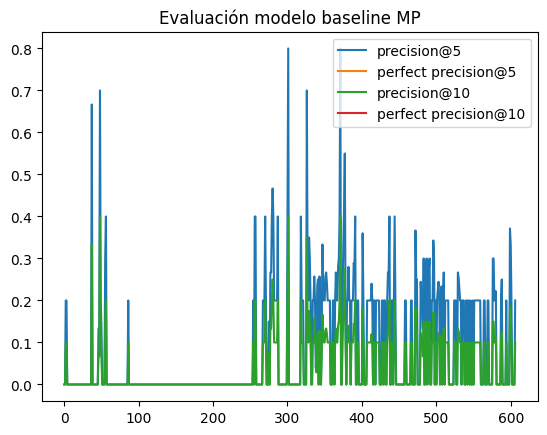

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0
mean,2023-06-22 00:00:00,0.338095,0.184127,0.110476,0.055238,0.036825,0.005524,0.338095,0.373100,0.373100,...,0.400000,0.311667,0.400000,0.400000,0.400000,0.400000,0.400000,0.092034,NaN,NaN
min,2023-06-13 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069970,NaN,NaN
25%,2023-06-17 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070470,NaN,NaN
50%,2023-06-22 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072900,NaN,NaN
75%,2023-06-26 12:00:00,0.702381,0.333333,0.200000,0.100000,0.066667,0.010000,0.702381,0.870674,0.870674,...,1.000000,0.570833,1.000000,1.000000,1.000000,1.000000,1.000000,0.121633,NaN,NaN
max,2023-07-01 00:00:00,1.000000,0.619048,0.371429,0.185714,0.123810,0.018571,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.128050,NaN,NaN
std,NaN,0.448648,0.252775,0.151665,0.075832,0.050555,0.007583,0.448648,0.483777,0.483777,...,0.516398,0.428610,0.516398,0.516398,0.516398,0.516398,0.516398,0.027086,NaN,NaN
